In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from higgsml.data import DataSet
from higgsml.plot import plot_corr_heatmap, set_style

%load_ext autoreload
%autoreload 2

In [2]:
set_style()

In [3]:
ds = DataSet()
plot_features = ds.get_data_features()

X_train, y_train, w_train = ds.get_train_data()
X_train = X_train.loc[:, plot_features]
X_test, y_test, w_test = ds.get_test_data()
X_test = X_test.loc[:, plot_features]

File already downloaded, skipping...


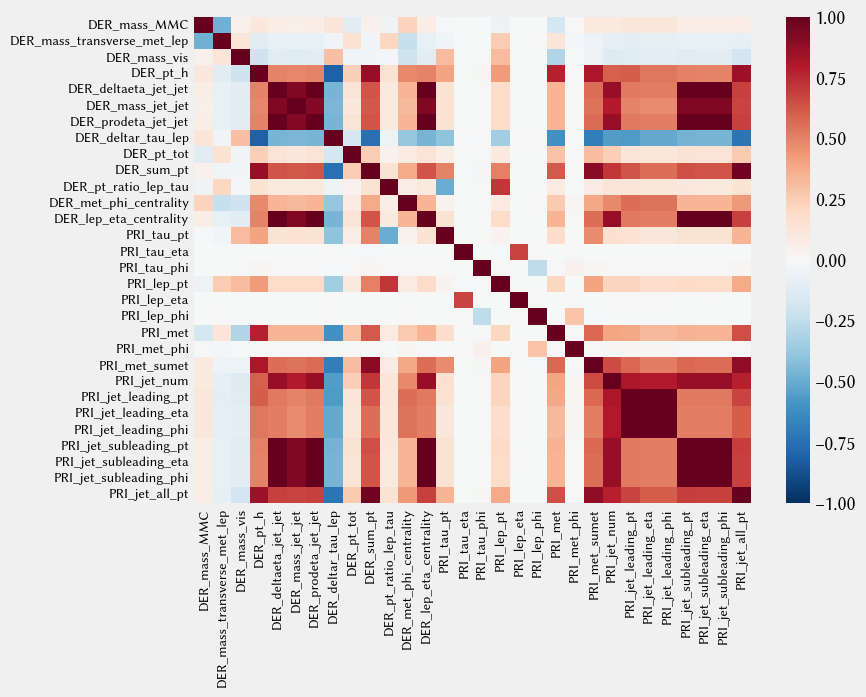

In [4]:
plot_corr_heatmap(X_train[y_train == "s"], plot_features)

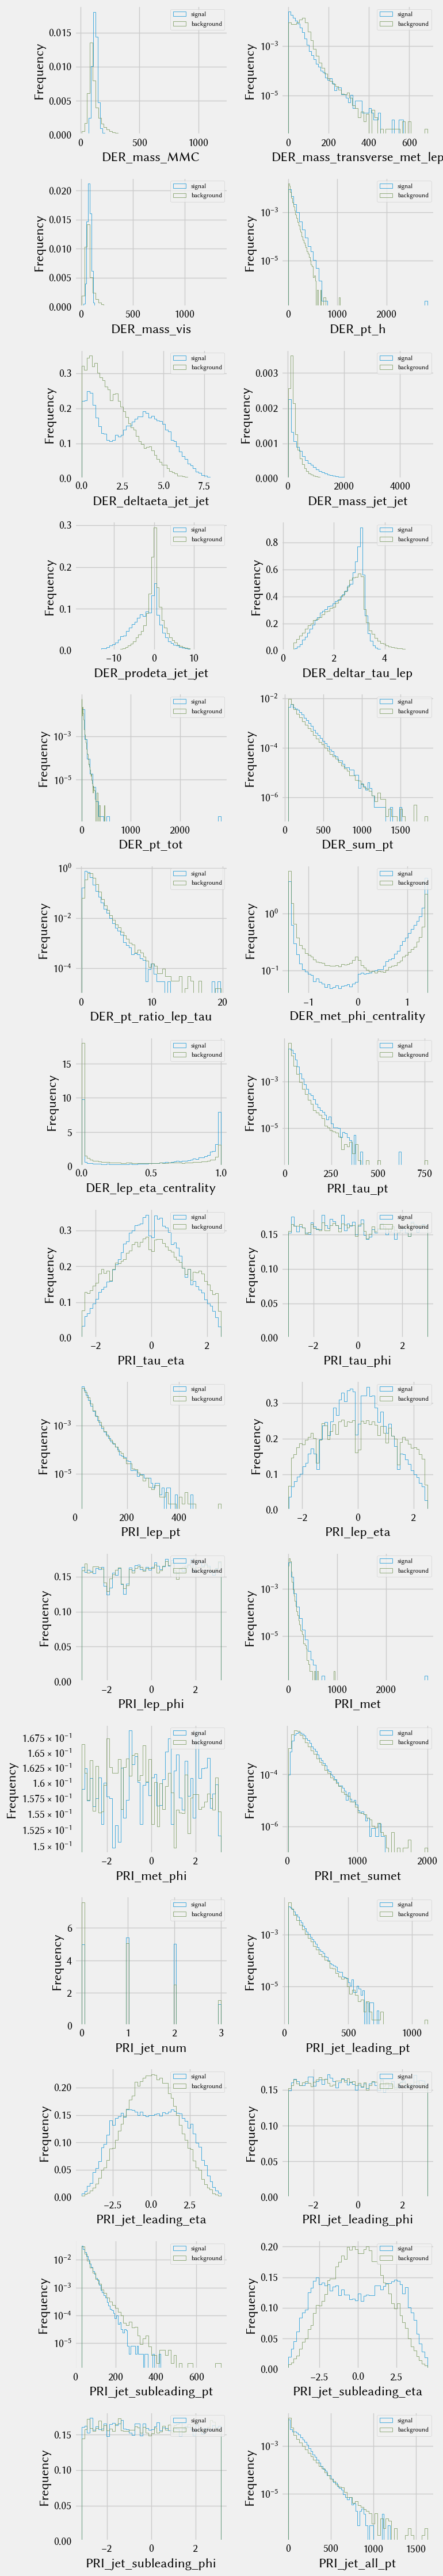

In [5]:
ncols = 2
nrows = int(np.ceil(len(plot_features)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(8, nrows*3))
for feature, ax in zip(plot_features, axes.flatten()):
    sel = (X_train[feature] > - 999)
    X_train.loc[sel & (y_train == "s"), feature].plot(kind="hist", ax=ax, histtype='step', bins=50, label="signal", color='C0', density=True)
    X_train.loc[sel & (y_train == "b"), feature].plot(kind="hist", ax=ax, histtype='step', bins=50, label="background", color='C3', density=True)
    ax.set_xlabel(feature)
    ax.legend(fontsize=8)
    if "pt" in feature or "met" in feature:
        ax.set_yscale("log")
plt.tight_layout()

Split dataset according to the number of jets

In [6]:
from higgsml.preprocessing import split_njets
splits = split_njets(X_train, y_train, w_train)

X_train_njets0, y_train_njets0, w_train_njets0 = splits[0]
X_train_njets1, y_train_njets1, w_train_njets1 = splits[1]
X_train_njets2p, y_train_njets2p, w_train_njets2p = splits[2]


splits = split_njets(X_test, y_test, w_test)

X_test_njets0, y_test_njets0, w_test_njets0 = splits[0]
X_test_njets1, y_test_njets1, w_test_njets1 = splits[1]
X_test_njets2p, y_test_njets2p, w_test_njets2p = splits[2]



In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
pipeline = Pipeline(
    [('scaler', StandardScaler()),
     ('bdt', XGBClassifier())
    ]
)

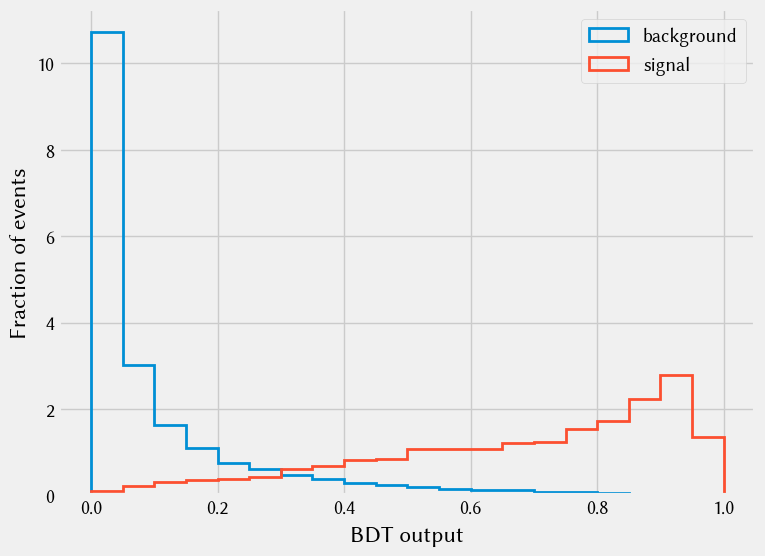

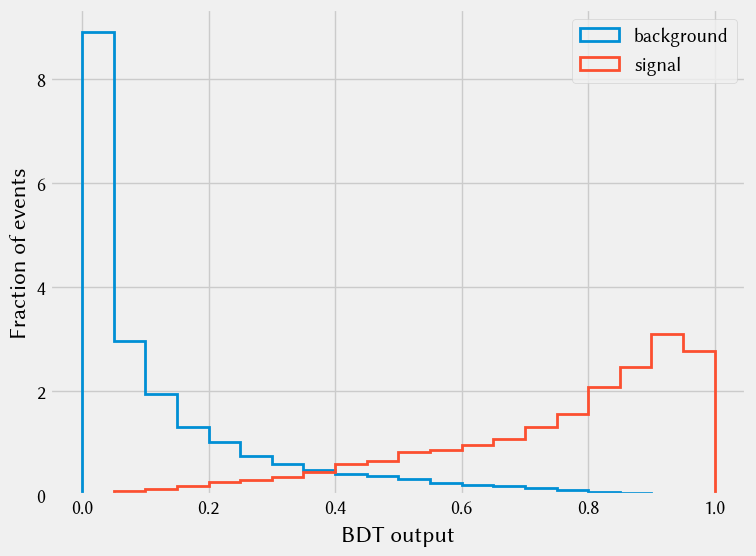

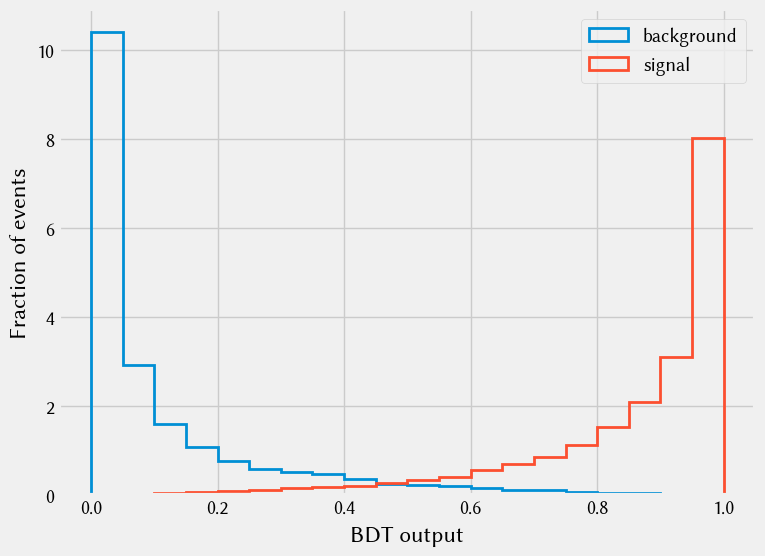

In [8]:
from higgsml.plot import plot_bdt_score

for data, labels, weights in splits.values():
    pipeline = Pipeline(
    [('scaler', StandardScaler()),
     ('bdt', XGBClassifier())
    ]
)
    pipeline.fit(data, labels == "s")
    plot_bdt_score(pipeline, data, labels)
    

In [9]:
from sklearn.model_selection import cross_validate, GridSearchCV

#cross_validate(pipeline, X_train_njets2p, y_train_njets2p == "s")
parameters = {
    "bdt__max_depth": [2, 4, 6],
    'bdt__n_estimators': [50, 100, 200] 
}
clf = GridSearchCV(pipeline, parameters, verbose=True, n_jobs=2)
clf.fit(X_train_njets2p, y_train_njets2p == "s")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('bdt',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=0, gpu_id=-1,
                                                      grow_policy='depthwise',
                                                      importance_type=None,
                                                      intera...
                                                      learning_rate=0.300000012,
                                                      max_bin=256,
                                                      max_cat_threshold=64,
                                                      max_cat_to_onehot=4,
                                                      max_delta_step=0,
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0, ...))]),
             n_jobs=2,
             param_grid={'bdt__max_depth': [2, 4, 6],
                         'bdt__n_estimators': [50, 100, 200]},
             verbose=True)

In [10]:
print(clf.best_params_)
best_bdt = clf.best_estimator_

{'bdt__max_depth': 4, 'bdt__n_estimators': 100}


In [11]:
from higgsml.stats import classifier_ams2
classifier_ams2(best_bdt, X_train_njets2p, w_train_njets2p)

3301.4132824274243 32071.377196970527


18.128737692845185

In [46]:
def ams_score(target, pred, weights):
    """Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )
    where b_r = 10, b = background, s = signal, log is natural logarithm.
    s and b are the unnormalised true positive and false positive rates,
    respectively, weighted by the weights of the dataset.
    """
    # true positive rate, weighted
    
    s = weights.dot(np.logical_and(pred == 1, target == 1))
    # false positive rate, weighted
    
    b = weights.dot(np.logical_and(pred == 1, target == 0))
    br = 10.0
    radicand = 2 *((s+b+br) * np.log(1.0 + s/(b+br)) - s)
    if radicand < 0:
        raise Exception("Radicand is negative.")
    else:
        return np.sqrt(radicand)

3783.200816737226 31458.117520676933
20.919472290380522
2.137954439992284
[0.662732336668577, 0.7092225906907162, 0.7635254108807126, 0.811113188968771, 0.8468953623928996, 0.8817790424439745, 0.9112584404625467, 0.9380050100270967, 0.9637769350801222, 0.9885378676659168, 1.0150313480012054, 1.0391174502578215, 1.0576799557930159, 1.0754840908033654, 1.0950125727173923, 1.1144867579749684, 1.134377971878672, 1.151797436061677, 1.168404522685872, 1.184868601136156, 1.1986979209956912, 1.2096281958649222, 1.2203360588387273, 1.233647260918424, 1.2477519958319314, 1.2611170270526215, 1.2757923434184155, 1.287608900649108, 1.2971327555064671, 1.3143502277400352, 1.3227894176611232, 1.3359416489817277, 1.351513266678768, 1.3595498585132373, 1.3611503623572172, 1.3753189269438968, 1.3850004997855865, 1.3967683189713396, 1.4062410919050912, 1.4176349617156774, 1.425860500905364, 1.4328106580625053, 1.4487064011244017, 1.462617728369408, 1.4709692407842876, 1.4783419947893226, 1.49383706366849

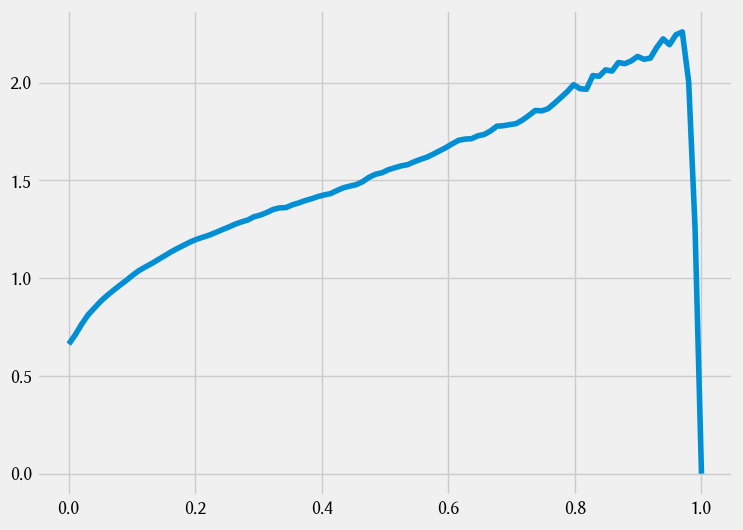

In [48]:
from higgsml.stats import classifier_ams2
print(classifier_ams2(best_bdt, X_test_njets2p, w_test_njets2p))
print(ams_score(y_test_njets2p == "s", best_bdt.predict_proba(X_test_njets2p)[:,1] > 0.9, w_test_njets2p))

thresholds = np.linspace(0, 1, 100)
ams = [ams_score(y_test_njets2p == "s", best_bdt.predict_proba(X_test_njets2p)[:,1] > thr, w_test_njets2p) for thr in thresholds]
plt.plot(thresholds, ams)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch.utils.data import DataLoader, TensorDataset

In [112]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train_njets2p)

In [151]:
class Net(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.dense1 = nn.Linear(num_features, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.dense2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dense3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.apply(self._init_weights)

    def forward(self, X):
        X = self.relu(self.dense1(X))
        X = self.dropout(X)
        X = self.relu(self.dense2(X))
        X = self.dropout2(X)
        X = self.relu(self.dense3(X))
        X = self.output(X)
        return X

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)

model = Net(X_scale.shape[1])
optim = Adam(model.parameters(), lr=3e-4)  

criterion = nn.BCEWithLogitsLoss()

ds = TensorDataset(torch.tensor(X_scale), torch.tensor(y_train_njets2p.values == "s"))
loader = DataLoader(ds, batch_size=128)

In [152]:
model.train()
running_loss = 0
i = 0
data = next(iter(loader))
for epoch in range(5000):    
        X, y = data
        X = X.to(torch.float32)
        # forward pass
        y = y.reshape((-1, 1)).to(torch.float32)
        scores = model(X)
        loss = criterion(scores, y)
        loss.backward()
        optim.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0 and epoch % 20 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.5f}')
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 6.17175
[21,     1] loss: 113.16443
[41,     1] loss: 91.61403
[61,     1] loss: 69.22993
[81,     1] loss: 48.75657
[101,     1] loss: 37.08694
[121,     1] loss: 36.69696
[141,     1] loss: 43.62801
[161,     1] loss: 49.27918
[181,     1] loss: 50.57599
[201,     1] loss: 50.02721
[221,     1] loss: 42.21742
[241,     1] loss: 35.08449
[261,     1] loss: 26.07591
[281,     1] loss: 19.95661
[301,     1] loss: 15.89141
[321,     1] loss: 13.74301
[341,     1] loss: 13.18518
[361,     1] loss: 12.99705
[381,     1] loss: 13.18546
[401,     1] loss: 14.14234
[421,     1] loss: 15.09090
[441,     1] loss: 13.42123
[461,     1] loss: 13.28843
[481,     1] loss: 11.75385
[501,     1] loss: 11.33942
[521,     1] loss: 9.89183
[541,     1] loss: 7.92376
[561,     1] loss: 7.72314
[581,     1] loss: 7.04315
[601,     1] loss: 6.64332
[621,     1] loss: 6.11088
[641,     1] loss: 6.15292
[661,     1] loss: 6.03488
[681,     1] loss: 5.88145
[701,     1] loss: 5.40832
[721,   

In [153]:
model.eval()
res1 = y.reshape(1, -1)#torch.Tensor((y == "s").values).to(torch.float32)
res2 = (model(torch.tensor(X, dtype=torch.float32)) > 0.5).to(torch.float32).reshape(1,-1)
(res1 == res2).to(torch.float32).mean()

/tmp/ipykernel_10864/61804986.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res2 = (model(torch.tensor(X, dtype=torch.float32)) > 0.5).to(torch.float32).reshape(1,-1)


tensor(0.5703)

In [155]:
model.desc

Net(
  (dense1): Linear(in_features=30, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [150]:
res1.sum()

tensor(55.)

In [94]:
model(torch.tensor(X, dtype=torch.float32))

/tmp/ipykernel_10864/3125586123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(X, dtype=torch.float32))


tensor([[-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-5.2957e+06],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-1.2397e-01],
        [-3.3555e+06],
        [-1